## Check Points

- Out Activation
    - tanh to image, x
    - sigmoid to discriminator, x

- Visualized
    - output, x
    - gradients, x
    - loss, x
    - gcam, x
    - activation output, x

In [1]:
%%capture
!pip install --upgrade git+https://github.com/crimson206/DataLoader@0.1.1
!pip install git+https://github.com/crimson206/DeepLearningDevelopment@0.1.9

In [2]:
import os
import pickle

experiments_path = "different_images_gans/"

## Experiments type 

In [ ]:
!pip install --upgrade git+https://github.com/crimson206/DeepLearningDevelopment@0.1.9

## Experiments type2

- Long Training1
    Used Experiment0 setup, but 20 epochs
    lr = 2e-4

- Long Training2
    Applied step scheduler. 
    lr, from 5e-4 to 6.4e-05

In [2]:
import torch
import torch.nn as nn
import pickle
import os
import time
import numpy as np

import matplotlib.pyplot as plt

from torchvision.utils import save_image

import torch.optim as optim
from tqdm import tqdm
from IPython.display import clear_output

from CrimsonDataLoader.dataloads.dataloads import load_mnist, load_cifar
from CrimsonDeepLearning.visualization.loggers import Logger
from CrimsonDeepLearning.visualization.plot_grads import plot_gradient_magnitudes, get_gradient_magnitudes
from CrimsonDeepLearning.visualization.plot_general import plot_dictionary, plot_images
from CrimsonDeepLearning.visualization.plot_features import plot_gcam_2d, get_activation_visualization
from CrimsonDeepLearning.utils.randomness import seed_everything

class GeneratorBlock(nn.Module):
    def __init__(self, in_channel, out_channel, norm=True, negative_slope=0.2):
        super(GeneratorBlock, self).__init__()

        layers = []
        layers.append(nn.Linear(in_channel, out_channel))
        if norm:
            layers.append(nn.BatchNorm1d(out_channel))
        layers.append(nn.LeakyReLU(negative_slope, inplace=True))

        self.layers = nn.Sequential(*layers)

    def forward(self, input_tensor):
        return self.layers(input_tensor)



class Generator(nn.Module):
    def __init__(self, image_shape, hidden_channels, negative_slope, tanh=True):
        super(Generator, self).__init__()

        layers = [
            GeneratorBlock(hidden_channels[i], hidden_channels[i+1], norm=False if i==0 else True, negative_slope=negative_slope)
            for i in range(len(hidden_channels)-1)
        ]

        self.layers = nn.Sequential(*layers)
        self.out_fc = nn.Linear(hidden_channels[-1], np.prod(image_shape))
        self.tanh = tanh
        self._image_shape = image_shape

    def forward(self, z_latent):
        output_tensor = z_latent

        output_tensor = self.layers(output_tensor)
        output_tensor = self.out_fc(output_tensor)
        output_tensor = output_tensor.view(output_tensor.size(0), *self._image_shape)
        if self.tanh:
            output_tensor = nn.functional.tanh(output_tensor)
        return output_tensor

class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channel, out_channel, negative_slope):
        super(DiscriminatorBlock, self).__init__()

        layers = [
            nn.Linear(in_channel, out_channel),
            nn.LeakyReLU(negative_slope, inplace=True)
        ]

        self.layers = nn.Sequential(*layers)

    def forward(self, input_tensor):
        return self.layers(input_tensor)

class Discriminator(nn.Module):
    def __init__(self, hidden_channels, negative_slope, out_size=1, sigmoid=True):
        super(Discriminator, self).__init__()

        layers = [
            DiscriminatorBlock(hidden_channels[i], hidden_channels[i+1], negative_slope)
            for i in range(len(hidden_channels)-1)
        ]

        self.layers = nn.ModuleList(layers)
        self.out_fc = nn.Linear(hidden_channels[-1], out_size)
        self.sigmoid = sigmoid

    def forward(self, input_tensor):

        intermediate = input_tensor.flatten(1, -1)
        for layer in self.layers:
            intermediate = layer.forward(intermediate)

        if self.sigmoid:
            output = nn.functional.sigmoid(self.out_fc.forward(intermediate))
        else:
            output = self.out_fc.forward(intermediate)
        return output

## Experiment 0

Hidden Sizes

generator, [128, 256, 512, 1024]
discriminator, [28*28, 512, 256]

Output Activation

generator, tanh
discriminator, sigmoid



In [3]:
def handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir):

    clear_output()
    loss_logger.epoch_step()
    plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"], primary_ylabel="Loss", secondary_ylabel="Time")
    plot_images(fake_image.detach())

    os.makedirs(save_dir, exist_ok=True)
    save_image(fake_image.data[:25], f"{save_dir}/generated_image_{done}.png", nrow=5, normalize=True)

    dis_grad_dict = get_gradient_magnitudes(discriminator)
    dis_grad_png = plot_gradient_magnitudes(dis_grad_dict, title="Discriminator Gradients")
    gen_grad_dict = get_gradient_magnitudes(generator)
    gen_grad_png = plot_gradient_magnitudes(gen_grad_dict, title="Generator Gradients")

    file_path = f"{save_dir}/discriminator_gradient_magnitudes_{done}.png"
    with open(file_path, "wb") as file:
        file.write(dis_grad_png)
    file_path = f"{save_dir}/generator_gradient_magnitudes_{done}.png"
    with open(file_path, "wb") as file:
        file.write(gen_grad_png)

In [4]:
def step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device):
    n_batch = image.shape[0]

    real_label = torch.ones(n_batch, 1).float().to(device)
    fake_label = 0 * real_label

    ### Prepare random noraml distribution

    z_latent = torch.randn(n_batch, n_latent).to(device)
    #z_latent = torch.normal(mean=0, std=1, size=(n_batch, n_latent))
    ### Prepare images

    real_image = image.to(device)
    fake_image = generator.forward(z_latent).detach()

    ### Train discriminator

    real_output = discriminator.forward(real_image)
    fake_output = discriminator.forward(fake_image)

    real_loss_D = cross_entropy_loss.forward(real_output, real_label)
    fake_loss_D = cross_entropy_loss.forward(fake_output, fake_label)

    loss_D = 0.5*real_loss_D + 0.5*fake_loss_D

    discriminator.zero_grad()
    loss_D.backward()
    optim_D.step()

    ### Train Generator

    fake_image = generator.forward(z_latent)

    deceived_output = discriminator.forward(fake_image)

    loss_G = - cross_entropy_loss.forward(deceived_output, fake_label)

    generator.zero_grad()
    loss_G.backward()

    optim_G.step()

    loss_D = real_loss_D + fake_loss_D
    current_time = time.time()

    time_spent = current_time - start_time

    loss_logger.batch_step([loss_D.clamp(0, 5).detach().item(), loss_G.clamp(-1, 0).detach().item(), time_spent], ["Loss D", "Loss G", "Time"])

    return fake_image

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

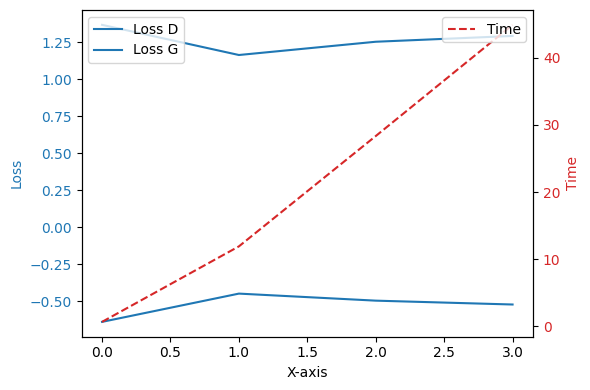

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


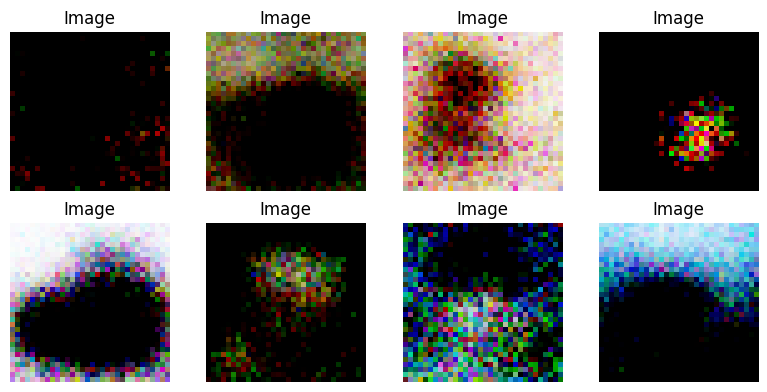

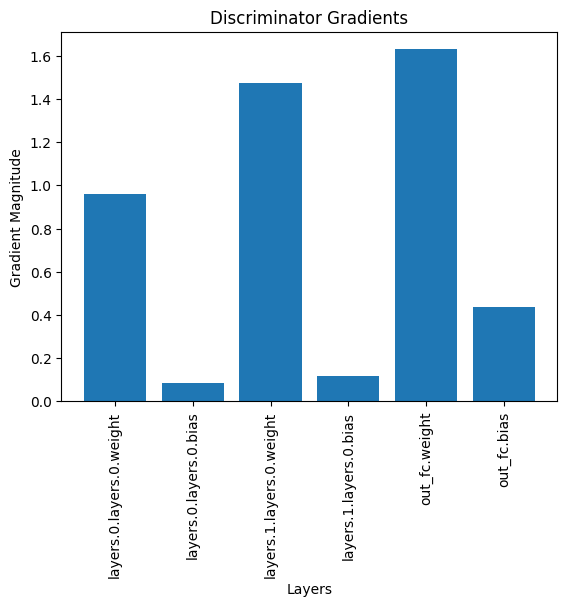

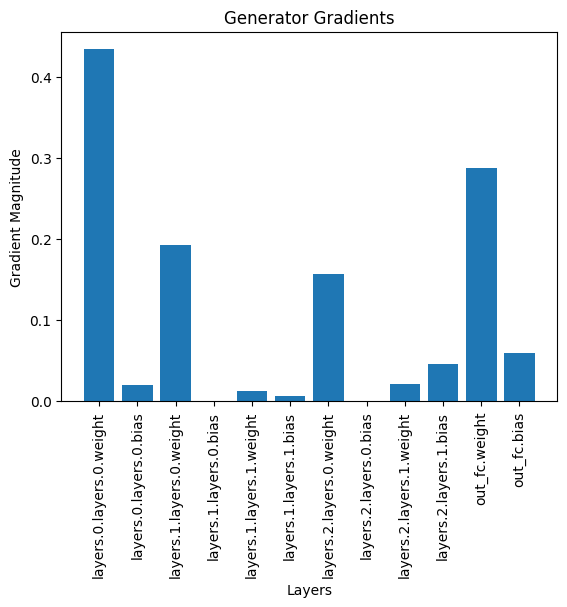

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


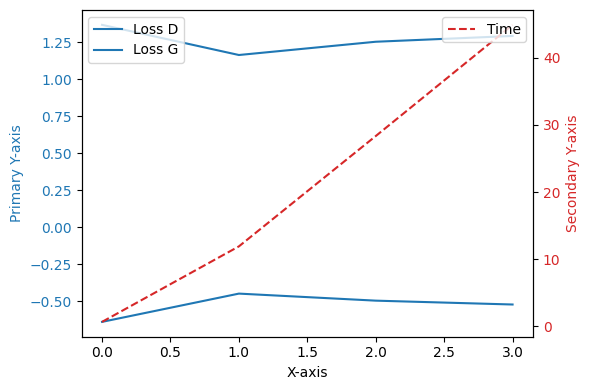

In [6]:
exp_name = "experiment0"
save_dir = f"basic_gans_experiment/{exp_name}"

train_dataset, train_loader, _, _ = load_cifar(batch_size=n_batch, num_classes=10, download=True)

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 256, 512, 1024],
    "discriminator_hidden_channels": [3*32*32, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
    "initial_lr":0.0005,
    "scheduler_step":1,
    "scheduler_gamma":0.95,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]



generator = Generator(image_shape=(3, 32, 32), hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)


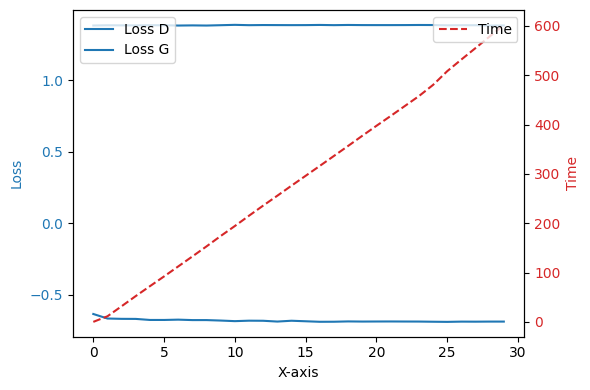

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


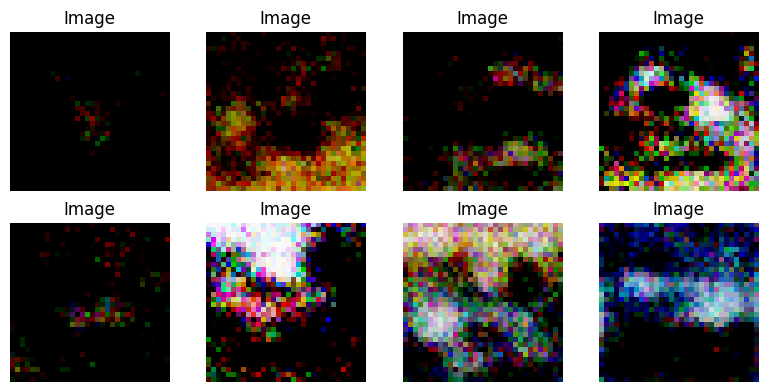

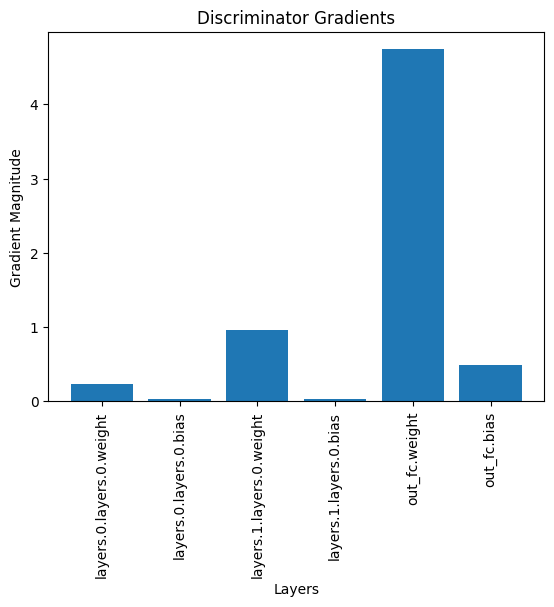

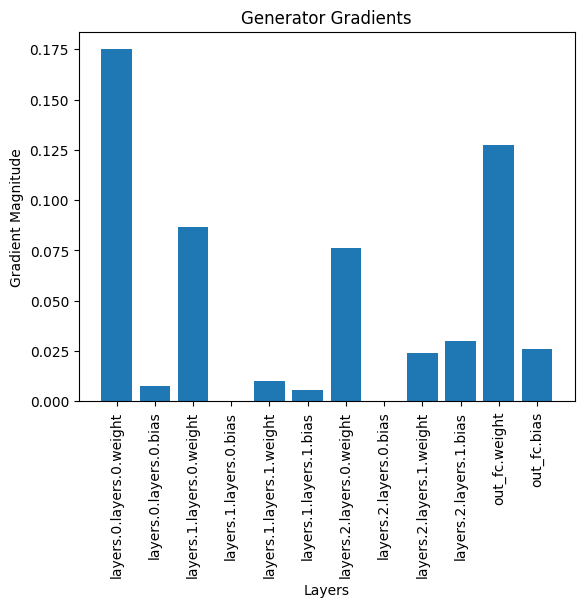

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [11]:

epochs = 10
checking_interval = 10000

n_batch = 32

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler_D = torch.optim.lr_scheduler.StepLR(optim_D, step_size=config_dict["scheduler_step"], gamma=config_dict["scheduler_gamma"])
scheduler_G = torch.optim.lr_scheduler.StepLR(optim_G, step_size=config_dict["scheduler_step"], gamma=config_dict["scheduler_gamma"])


cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if done%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)
            scheduler_D.step()
            scheduler_G.step()

loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

In [ ]:

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)
            lr_logger.batch_step(values = [optim_D.param_groups[0]["lr"]], labels = ["Learning Rate"])
            plot_dictionary(lr_logger.batch_values_dict)


In [12]:
from CrimsonDataLoader.editors.image_editor import add_diversity_to_grey_image
from CrimsonDeepLearning.utils.data import DictionaryDataset
from torch.utils.data import DataLoader
from CrimsonDeepLearning.utils.data import Dataset

In [28]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [22]:
exp_name = "experiment1"
save_dir = f"basic_gans_experiment/{exp_name}"



In [26]:
exp_name = "experiment1"
save_dir = f"basic_gans_experiment/{exp_name}"
image_shape=(3, 28, 28)

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch, download=True)

tensor_dict = add_diversity_to_grey_image(train_loader)
train_dataet = CustomImageDataset(tensor_dict["image"], tensor_dict["labels"])
train_loader = DataLoader(dataset=train_dataet, batch_size=n_batch, shuffle=True)

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 256, 512, 1024],
    "discriminator_hidden_channels": [3*28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
    "initial_lr":0.0005,
    "scheduler_step":1,
    "scheduler_gamma":0.95,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]



generator = Generator(image_shape=image_shape, hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)

loss_logger = Logger()

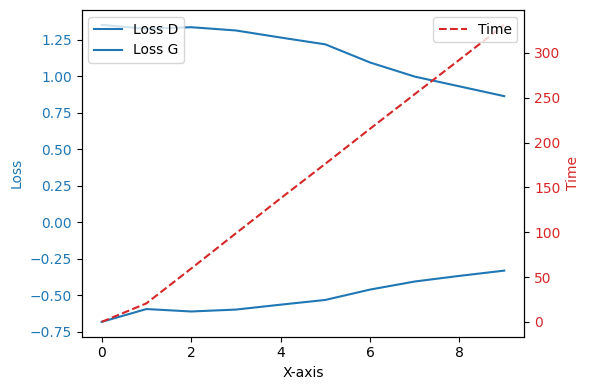

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


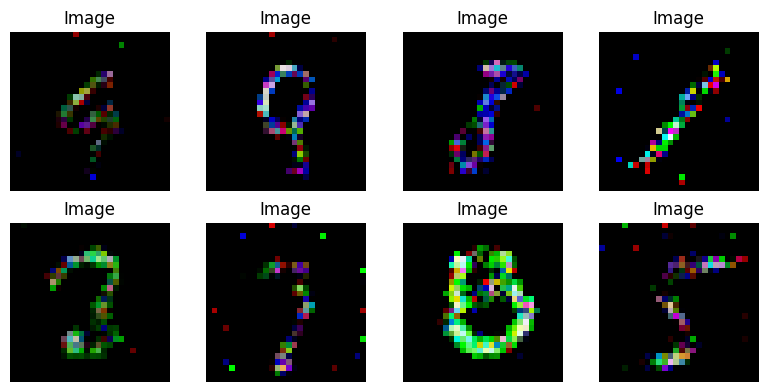

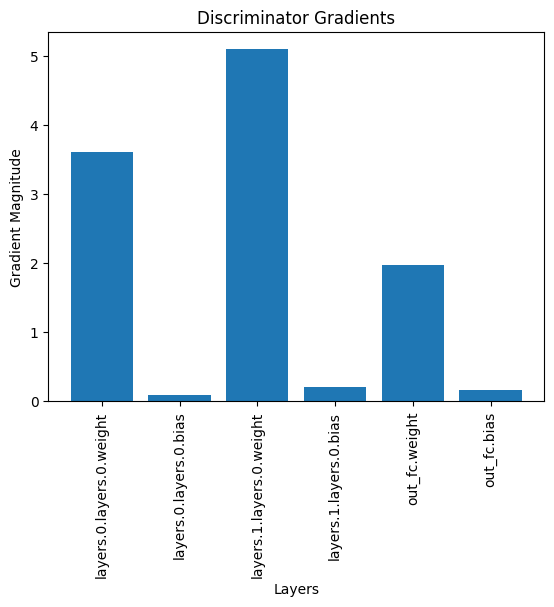

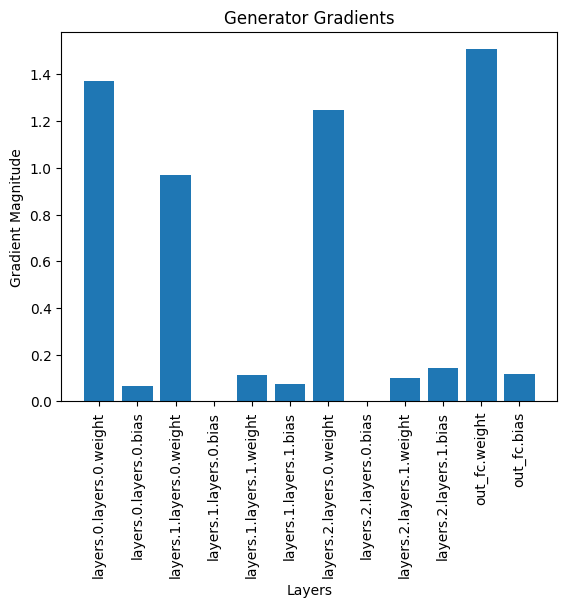

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


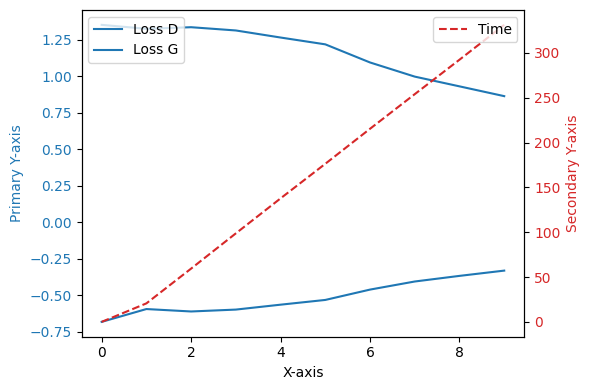

In [27]:

epochs = 20
checking_interval = 4000

n_batch = 32

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler_D = torch.optim.lr_scheduler.StepLR(optim_D, step_size=config_dict["scheduler_step"], gamma=config_dict["scheduler_gamma"])
scheduler_G = torch.optim.lr_scheduler.StepLR(optim_G, step_size=config_dict["scheduler_step"], gamma=config_dict["scheduler_gamma"])


cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if done%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)
            scheduler_D.step()
            scheduler_G.step()

loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

In [32]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

# Define a custom rotation transform
class RandomRotationTransform:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)  # Choose a random angle
        return transforms.functional.rotate(x, angle)

# Define the transformation pipeline with your custom rotation
transform = transforms.Compose([
    RandomRotationTransform(angles=[0, 90, 180, 270]),  # Add your discrete angles here
])


In [33]:
exp_name = "experiment2"
save_dir = f"basic_gans_experiment/{exp_name}"
image_shape=(3, 28, 28)

train_dataet = CustomImageDataset(tensor_dict["image"], tensor_dict["labels"], transform)
train_loader = DataLoader(dataset=train_dataet, batch_size=n_batch, shuffle=True)

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 256, 512, 1024],
    "discriminator_hidden_channels": [3*28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
    "initial_lr":0.0005,
    "scheduler_step":1,
    "scheduler_gamma":0.95,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]



generator = Generator(image_shape=image_shape, hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)

loss_logger = Logger()

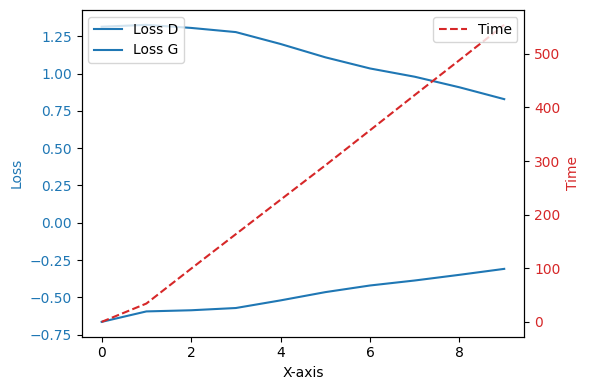

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


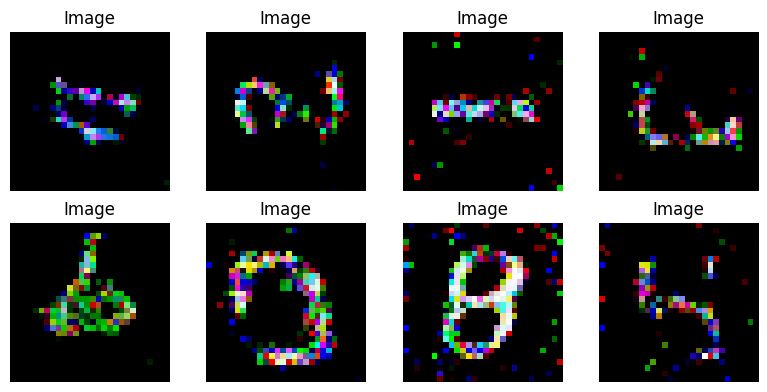

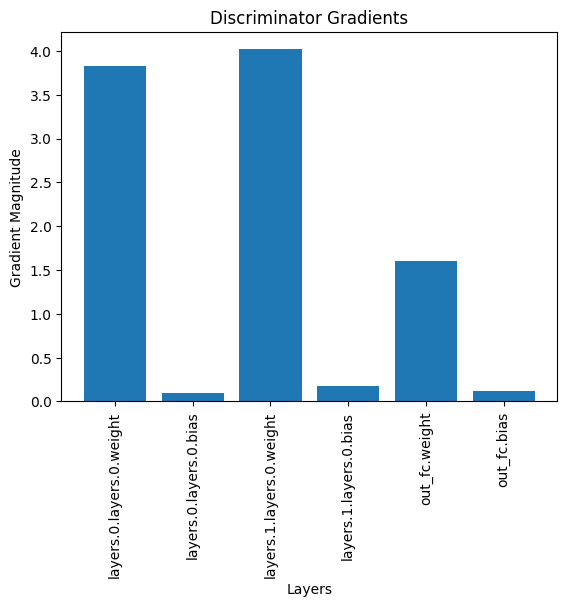

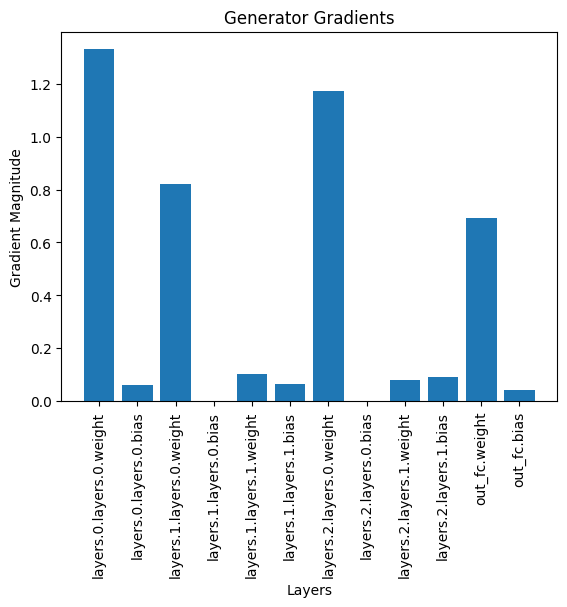

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


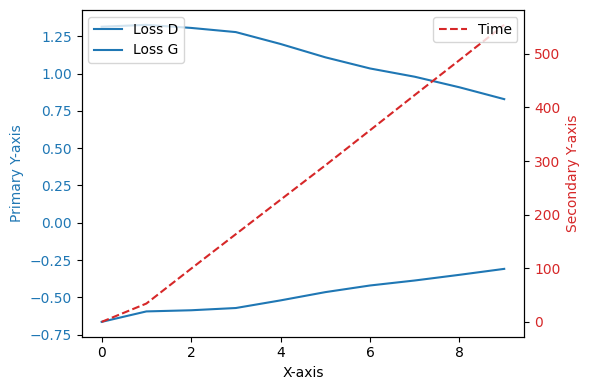

In [34]:

epochs = 20
checking_interval = 4000

n_batch = 32

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler_D = torch.optim.lr_scheduler.StepLR(optim_D, step_size=config_dict["scheduler_step"], gamma=config_dict["scheduler_gamma"])
scheduler_G = torch.optim.lr_scheduler.StepLR(optim_G, step_size=config_dict["scheduler_step"], gamma=config_dict["scheduler_gamma"])


cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if done%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)
            scheduler_D.step()
            scheduler_G.step()

loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)